<a href="https://colab.research.google.com/github/davyandr/pet-projects/blob/main/ab/ab_ratio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт

In [1]:
! gdown 1z-2e19EAJ85nKm4ybzWirZGjH5dPxdof

Downloading...
From: https://drive.google.com/uc?id=1z-2e19EAJ85nKm4ybzWirZGjH5dPxdof
To: /content/ab_test_ctr.csv
100% 130k/130k [00:00<00:00, 3.69MB/s]


https://drive.google.com/file/d/1z-2e19EAJ85nKm4ybzWirZGjH5dPxdof/view?usp=sharing

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as ss
import warnings
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
df = pd.read_csv('/content/ab_test_ctr.csv')
df.head()

,user_id,test,views,clicks
0,19981,0,55,2
1,75961,0,68,7
2,75576,0,68,5
3,53989,0,35,4
4,71118,0,34,3


In [4]:
df['ctr'] = df.clicks / df.views

In [8]:
print('Sizes of groups:\n')
df.test.value_counts()

Sizes of groups:



0    5000
1    5000
Name: test, dtype: int64

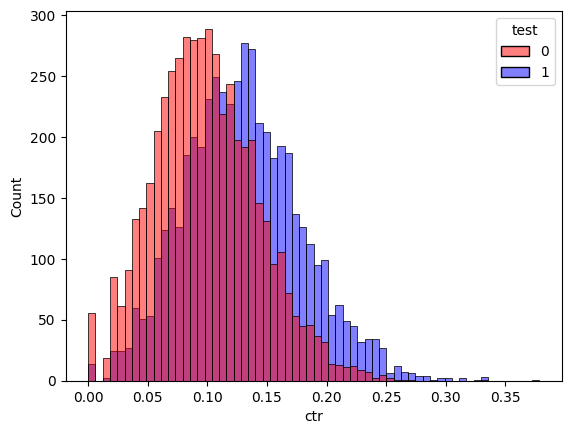

In [9]:
sns.histplot(data = df, x='ctr', hue='test', palette = ['r', 'b'], alpha=0.5, kde=False);

В эксперименте измеряем CTR

## $CTR_u = \frac{Clicks_u}{Views_u}$  

Клики и просмотры зависимые величины, поэтому будем использовать Дельта метод для вычисления дисперсии

## $R = \frac{\sum\limits_{i=1}^n Clicks_i}{\sum\limits_{i=1}^nViews_i}$  

$H_0$: CTR(control) = CTR(experiment)\
$H_1$: CTR(control) ≠ CTR(experiment)

## $Var(\frac{X}{Y}) \approx  \frac{1}{μ_y^2} Var(X) - 2\frac{\mu_x}{μ_y^3} cov(X, Y) + \frac{\mu_x^2}{μ_y^4} Var(Y)$

## $Var(R) \approx  \frac{1}{n}(\frac{1}{μ_y^2} Var(X) - 2\frac{\mu_x}{μ_y^3} cov(X, Y) + \frac{\mu_x^2}{μ_y^4} Var(Y))$

Тогда формула для статистики Стьюдента:

## $t = \frac{R_B - R_A}{\sqrt {Var(R_A) + Var(R_B)}}$

In [21]:
def get_ttest_delta(X1, #clicks of A
                    X2, #clicks of B
                    Y1, #views of A
                    Y2  #views of B
                    ):

  R1 = X1.sum() / Y1.sum()
  R2 = X2.sum() / Y2.sum()

  var_R1 = (1 / len(X1))     *      (X1.var() / (Y1.mean() ** 2)     - 2 * X1.mean() * (X1.cov(Y1))/ (Y1.mean() ** 3)     + (X1.mean() ** 2) * Y1.var() / (Y1.mean() ** 4))
  var_R2 = (1 / len(X2))     *      (X2.var() / (Y2.mean() ** 2)     - 2 * X2.mean() * (X2.cov(Y2))/ (Y2.mean() ** 3)     + (X2.mean() ** 2) * Y2.var() / (Y2.mean() ** 4))

  t = (R2 - R1) / ((var_R1 + var_R2)**0.5)


  pvalue = (1 - ss.norm.cdf(np.abs(t))) * 2

  return t, pvalue


In [22]:
get_ttest_delta(
    df[df['test'] == 0].clicks,
    df[df['test'] == 1].clicks,
    df[df['test'] == 0].views,
    df[df['test'] == 1].views,
    )

(32.903989200927576, 0.0)

P value меньше 0.05, значит отклоняем нулевую гипотезу
# Раскатываем тестовую версию